In [1]:
import funclib as flib
import matplotlib as mplt

Read data

In [2]:
data = {}
for group in ["Mammals", "Birds"]:
    model_params, xy_data = flib.read_model_xy(group, "./../../scripts/pgls_res/ee5")
    data[group] = {"params":model_params,
                   "xy":xy_data}
palette = pd.read_csv("./../../data/plot_colors.tsv",sep="\t").set_index("Order").to_dict()["Color"]
sp2common = pd.read_csv("../../data/latin2common_shortened.txt",sep="\t").set_index("Species").to_dict()["Common_names"]

Figure 4

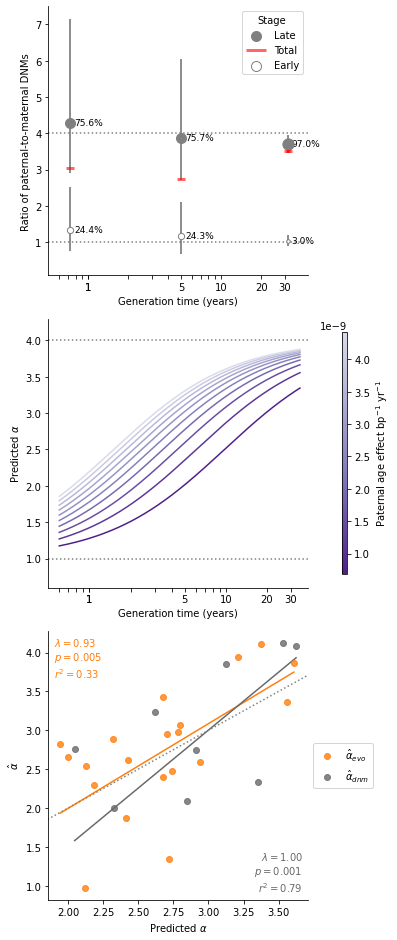

In [4]:
f,axs0 = plt.subplots(3, 1, figsize=[5.4,12.95],constrained_layout=True)
axs = axs0.reshape(-1)

##########################
##### Common styling #####
##########################
alpha_y_range = [0.6, 4.3]
g_x_range = [np.log10(0.5), np.log10(40)]
original_Gs = list(np.linspace(0.6,1,5)) + list(range(1,11)) + [20,30]
xlabels = ["" if g not in [1,5,10,20,30] else g for g in original_Gs]
log10_Gs = np.log10(original_Gs)

##########################
######## Panel A #########
##########################
ax = axs[0]

####### Read data ########
dnm_stages = pd.read_csv("../../data/dnm_stages.csv")
total_paternal = dnm_stages.groupby("Species").apply(lambda x: x.Paternal.sum()).to_dict()
total_maternal = dnm_stages.groupby("Species").apply(lambda x: x.Maternal.sum()).to_dict()
species_ages = dnm_stages.set_index("Species")["Parental_age"].to_dict()

##### Add All (Total) ####
frac_ee = {}
for sp,df in dnm_stages.groupby("Species"):
    m_dnms, p_dnms = flib.extraploate_parental_dnms(df)
    total_alpha = p_dnms/m_dnms
    all_df = pd.DataFrame([sp, p_dnms, m_dnms, p_dnms+m_dnms, "All", species_ages[sp]]).transpose()    
    all_df.columns = dnm_stages.columns
    dnm_stages = pd.concat([dnm_stages,all_df])
    ee = flib.fraction_ee(df)
    frac_ee[sp] = ee   
dnm_stages = dnm_stages.reset_index(drop=True)
dnm_stages = flib.add_binomial_CIs(dnm_stages)
dnm_stages["Parental_age_log"] = np.log10(list(dnm_stages.Parental_age))
#dnm_stages = dodge_positions(dnm_stages, "Parental_age_log", "Stage", ["Early_embryonic","PostPGCS","All"], 0.03)
dnm_stages = dnm_stages.replace("Early_embryonic","Early").replace("PostPGCS","Late")

###### Plot scatter ######
margin = 0.03
for sp,df in dnm_stages.groupby("Species"):
    
    all_alpha = df[df.Stage=="All"]["point"].values[0]
    ee_dnm = df[df.Stage=="Early"]["point"].values[0]
    postpgcs_dnm = df[df.Stage=="Late"]["point"].values[0]
    g = df[df.Stage=="Early"]["Parental_age_log"].values[0]
    
    ### EE ###
    ax.scatter(g, ee_dnm, c="white", edgecolor="gray", zorder=10, s=int(frac_ee[sp]*120)+10) 
    ax.annotate("{:.1f}%".format(frac_ee[sp]*100), xy=(g+margin, ee_dnm), va="center", fontsize=9)
    
    ### Post-PGCS ###
    ax.scatter(g, postpgcs_dnm, c="gray", edgecolor="gray", zorder=10, s=int((1-frac_ee[sp])*120)+10)
    ax.annotate("{:.1f}%".format((1-frac_ee[sp])*100), xy=(g+margin, postpgcs_dnm), va="center", fontsize=9)
    
    ### All (Total) ###
    xmin = df.Parental_age_log.values[0] - margin
    xmax = df.Parental_age_log.values[0] + margin
    ax.hlines(y=all_alpha, xmin=xmin, xmax=xmax,
              color="red", zorder=10, linewidth=3, alpha=0.6)
    
    ### Legend ###
    if sp=="Homo_sapiens":
        ax.scatter(1e3,1e3,s=100,c="gray", edgecolor="gray", label="Late")
        ax.hlines(y=all_alpha, xmin=xmin+(margin/2), xmax=xmax-(margin/2),
                  color="red", zorder=10, linewidth=3, alpha=0.6, label="Total")
        ax.scatter(1e3,1e3,s=100,c="white", edgecolor="gray", label="Early")
           
###### Plot CIs ########
for i,r in dnm_stages[dnm_stages.Stage!="All"].iterrows():
    ax.vlines(x = r.Parental_age_log, ymin = r.low, ymax = r.high,color="dimgray")

####### Styling ########
ax.legend(title="Stage")
ax.axhline(y=4, color="gray",linestyle="dotted",label="")
ax.axhline(y=1, color="gray",linestyle="dotted",label="")

######## Axis #########
ax.set_xlim([g_x_range[0], g_x_range[1]+0.05])
ax.set_ylim([0.085, 7.496])
ax.set_xticks(log10_Gs)
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"Generation time (years)")
ax.set_ylabel("Ratio of paternal-to-maternal DNMs")

##########################
######## Panel B #########
##########################
ax=axs[1]

####### Read data ########
rates_df = pd.read_csv("../../data/subrate_div_data.txt",sep="\t")
yearly_rates = rates_df[rates_df.Subset=="Mammals"].sort_values(by="MutPerYearUCSC", ascending=False).set_index("Species")["MutPerYearUCSC"].to_dict()
yearly_rates = {k:v/1e6 for k,v in yearly_rates.items()}
mammal_traits = data["Mammals"]["xy"]
log_gen_times = mammal_traits[mammal_traits.experiment=="Generation_time_y.Alpha"].set_index("Species")["xvar"].to_dict()
gen_times = {k:(10**v) for k,v in log_gen_times.items()}

######## Params #########
n_e = 5/3e9
Gs = list(np.linspace(0.6, 1, 1000)) + list(np.linspace(1, 35, 1000))
n_partitions = 10
species = list(yearly_rates.keys())

### Parental age effects ###
mu_ms = []
paternal_effects = {}
for i,sp in enumerate(species):
    mu_f, mu_m = flib.get_parental_age_effects(yearly_rates[sp], gen_times[sp], gen_times[sp], n_e, 4)
    paternal_effects[sp] = mu_m
    mu_ms.append(mu_m)
mu_m_space = np.linspace(min(mu_ms),max(mu_ms),n_partitions)
cmap = plt.get_cmap('Purples_r')
new_cmap = flib.truncate_colormap(cmap, 0.1, 0.75)
norm = mplt.colors.Normalize(vmin=min(mu_ms), vmax=max(mu_ms), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=new_cmap)
curves = [ax.plot(np.log10(Gs), [flib.predict_alpha(mu_m/4, mu_m, g, g, n_e) for g in Gs],c=mapper.to_rgba(mu_m)) for i,mu_m in enumerate(mu_m_space)]
toy_points = ax.scatter([100]*n_partitions, mu_m_space, c=mu_m_space, cmap=new_cmap) 
    
####### Styling ########
ax.axhline(y=4, linestyle="dotted", color="gray")
ax.axhline(y=1, linestyle="dotted", color="gray")
cbar = plt.colorbar(toy_points, ax=ax, shrink=0.9)#axs[1:2],aspect=100,shrink=0.5
cbar.set_label(r"Paternal age effect bp$^{-1}$ yr$^{-1}$")

######## Axis #########
ax.set_xlim(g_x_range)
ax.set_ylim(alpha_y_range)
ax.set_xticks(log10_Gs)
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"Generation time (years)")
ax.set_ylabel(r"Predicted $\alpha$")

##########################
######## Panel C #########
##########################
ax = axs[2]

####### Read data ########
dnm_params, dnm_data = flib.read_model_xy("DNMs", "./../../scripts/pgls_res/ee5/")
data["DNMs"] = {"params":dnm_params, "xy":dnm_data}
pred_alpha_evo = mammal_traits[mammal_traits.experiment=="Predicted_alpha_evo.Alpha"].reset_index(drop=True)
pred_alpha_dnm = dnm_data[dnm_data.experiment=="Predicted_alpha_dnms_min2trios.Alpha_dnm"].reset_index(drop=True)

######## Scatter #########
group = "Mammals"
color = "C1"
stats = flib.plot_pgls(data, group, "Predicted_alpha_evo.Alpha", "pgls_ml", ax, 
                       color, True, 0.8, True, r"$\hat{\alpha}_{evo}$")
ax.text(s = r"$\lambda={:.2f}$".format(stats["lambda"]) + "\n" + r"$p={:.3f}$".format(stats["pval"]) + "\n" + r"$r^2={:.2f}$".format(stats["r2"]),
        x=0.02, y=0.98, va="top",ha="left", transform=ax.transAxes,color=color)

group = "DNMs"
color = "dimgray"
stats = flib.plot_pgls(data, group, "Predicted_alpha_dnms_min2trios.Alpha_dnm", "pgls_ml", ax, 
                       color, True, 0.8, True, r"$\hat{\alpha}_{dnm}$")
ax.text(s = r"$\lambda={:.2f}$".format(stats["lambda"]) + "\n" + r"$p={:.3f}$".format(stats["pval"]) + "\n" + r"$r^2={:.2f}$".format(stats["r2"]),
        x=0.98, y=0.02, va="bottom",ha="right", transform=ax.transAxes,color=color)

flib.identity_line(ax,color="gray", ls="dotted")

##### Species labels #####
#selected_species = ["Homo_sapiens","Equus_caballus","Pongo_abelii","Ovis_aries","Canis_lupus_familiaris","Felis_catus",
#                    "Macaca_mulatta","Mus_musculus","Callithrix_jacchus","Bos_taurus","Sus_scrofa"]
#plot_sp_text(data, group, "Predicted_alpha_evo.Alpha", sp2common, selected_species, ax, ["black"]*len(colors))


####### Styling ########
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel(r"Predicted $\alpha$")
ax.set_ylabel(r"$\hat{\alpha}$")

sns.despine()
f.savefig("../pdfs/Figure_4_ee5.pdf")

In [ ]:
####### Read data ########
#pred_alpha = mammal_traits[mammal_traits.experiment=="Predicted_alpha_evo.Alpha"].reset_index(drop=True)

######## Scatter #########
#group = "Mammals"
#sns.regplot(data=pred_alpha,x="xvar",y="yvar",ax=ax,scatter=False,color="gray",ci=None)
#stats = flib.plot_pgls(data, group, "Predicted_alpha_evo.Alpha", "pgls_ml", ax, 
#                  palette["Mammals"], True, 0.8, True, False)
#flib.identity_line(ax,color="gray", ls="dotted")
#colors = [mapper.to_rgba(paternal_effects[sp]) for sp in pred_alpha.Species]

##### Species labels #####
#selected_species = ["Homo_sapiens","Equus_caballus","Pongo_abelii","Ovis_aries","Canis_lupus_familiaris","Felis_catus",
#                    "Macaca_mulatta","Mus_musculus","Callithrix_jacchus","Bos_taurus","Sus_scrofa"]
#flib.plot_sp_text(data, group, "Predicted_alpha_evo.Alpha", sp2common, selected_species, ax, ["black"]*len(colors))

######## Stats #########
#ax.text(s = r"$\lambda={:.2f}$".format(stats["lambda"]) + "\n" + r"$p={:.3f}$".format(stats["pval"]) + "\n" + r"$r^2={:.2f}$".format(stats["r2"]),
#        x=0.02, y=0.98, va="top",ha="left", transform=ax.transAxes,color="black")

####### Styling ########
#ax.set_xlabel(r"Predicted $\alpha$")
#ax.set_ylabel(r"$\hat{\alpha}_{evo}$")

######## Axis #########
#ax.set_xlim(alpha_y_range)
#ax.set_ylim(alpha_y_range)

Extra figures, yet to place in own notebook

In [12]:
def predict_yearly_rate(mu_ee, mu_f, mu_m, G_f, G_m):
    '''Predicts yearly mutation rate'''
    return (2*mu_ee + (mu_f*G_f) + (mu_m*G_m))/(G_f+G_m)

In [13]:
sp = "Macaca_mulatta"
n_e = 5/3e9
y_rate = yearly_rates[sp]
averaged_g = gen_times[sp]
ratio_g = 1
Gs = list(np.linspace(0.6, 1, 1000)) + list(np.linspace(1, 35, 1000)) #+ list(np.linspace(35,1e3,100))
log10_Gs = np.log10(Gs)
mu_f, mu_m = get_paternal_age_effects(y_rate, averaged_g, averaged_g, n_e, 4)

In [14]:
results_l = []
for mu_m in mu_m_space:
    for G in Gs:
        y_rate = predict_yearly_rate(n_e, mu_m/4, mu_m, G, G)
        results_l.append([mu_m, G, y_rate])

In [15]:
results_df = pd.DataFrame(results_l)
results_df.columns = ["mu_m","G","y_rate"]
results_df["log_G"] = np.log10(results_df.G)

In [16]:
t1 = pd.read_csv("../../data/Table_S1_v4.csv")
subd = t1[t1.Group=="Mammals"]

/Users/marc/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


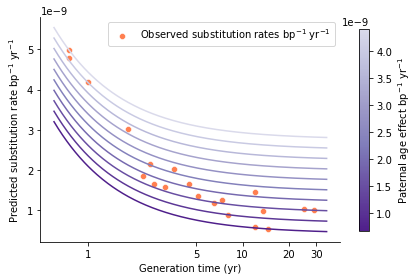

In [17]:
f,ax = plt.subplots()

cmap = plt.get_cmap('Purples_r')
new_cmap = truncate_colormap(cmap, 0.1, 0.75)
sns.lineplot(data=results_df, x="log_G",y="y_rate",hue="mu_m",palette=new_cmap,ax=ax,legend=False)
sns.scatterplot(np.log10(subd.Generation_time_y), subd.MutPerYearUCSC/1e6,color="coral",label="Observed substitution rates bp$^{-1}$ yr$^{-1}$")
label_Gs = [1,5,10,20,30]
xlabels = [1,5,10,20,30]
log10_Gs = np.log10(label_Gs)
ax.set_xticks(log10_Gs)
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"Generation time (yr)")
ax.set_ylabel(r"Predicted substitution rate bp$^{-1}$ yr$^{-1}$")
cbar = plt.colorbar(toy_points, ax=ax, shrink=0.9)#axs[1:2],aspect=100,shrink=0.5
cbar.set_label(r"Paternal age effect bp$^{-1}$ yr$^{-1}$")
sns.despine()
plt.tight_layout()
#plt.savefig("../../notebooks/pdfs/Predicted_yearly_rates.pdf")

In [24]:
pred_alpha.columns = ["Species","Predicted_alpha_evo","Alpha_evo","experiment"]

In [48]:
uni_paternal_effect = 3e-9
n_e = 5/3e9
pred_alpha["Predicted_alpha_evo_unipaternal"] = [predict_alpha(uni_paternal_effect/4, uni_paternal_effect, gen_times[r.Species], gen_times[r.Species], n_e) for i,r in pred_alpha.iterrows()]

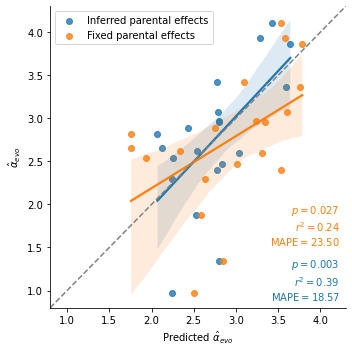

In [156]:
f,ax = plt.subplots(figsize=[5,5])
sns.regplot(data=pred_alpha, x="Predicted_alpha_evo",y="Alpha_evo",ax=ax,label="Inferred parental effects")
r,pval = stats.pearsonr(pred_alpha.Predicted_alpha_evo,pred_alpha.Alpha_evo)
r2 = r**2
mape = mean_absolute_percentage_error(pred_alpha.Predicted_alpha_evo,pred_alpha.Alpha_evo)
ax.text(s = r"$p={:.3f}$".format(pval) + "\n" + r"$r^2={:.2f}$".format(r2) + "\n" + r"MAPE$={:.2f}$".format(mape),
        x=0.98, y=0.02, va="bottom",ha="right", transform=ax.transAxes,color="C0")

sns.regplot(data=pred_alpha, x="Predicted_alpha_evo_unipaternal",y="Alpha_evo",ax=ax, label="Fixed parental effects")
r,pval = stats.pearsonr(pred_alpha.Predicted_alpha_evo_unipaternal,pred_alpha.Alpha_evo)
r2 = r**2
mape = mean_absolute_percentage_error(pred_alpha.Predicted_alpha_evo_unipaternal,pred_alpha.Alpha_evo)
ax.text(s = r"$p={:.3f}$".format(pval) + "\n" + r"$r^2={:.2f}$".format(r2) + "\n" + r"MAPE$={:.2f}$".format(mape),
        x=0.98, y=0.2, va="bottom",ha="right", transform=ax.transAxes,color="C1")


identity_line(color="gray")
ax.set_ylabel(r"$\hat{\alpha}_{evo}$")
ax.set_xlabel(r"Predicted $\hat{\alpha}_{evo}$")
ax.legend()
range_axes = [0.8,4.3]
ax.set_xlim(range_axes)
ax.set_ylim(range_axes)
sns.despine()
plt.tight_layout()
plt.savefig("../../notebooks/pdfs/Predicted_alpha_evo_uniform-inferred.pdf")

In [112]:
from scipy import stats
from sklearn.metrics import mean_absolute_error

In [128]:
def mean_absolute_percentage_error(y_true, y_pred): 
    #actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [144]:
np.mean([3e-9,3e-9/4])

1.875e-09

In [145]:
pred_yrates_l = []
uni_paternal_effect = 3e-9
n_e = 5/3e9
for sp,g in gen_times.items():
    pred_yrates_l.append([sp,predict_yearly_rate(n_e, uni_paternal_effect/4, uni_paternal_effect, g, g),yearly_rates[sp],g])
pred_yrates = pd.DataFrame(pred_yrates_l)
pred_yrates.columns = ["species","pred_yrate","yrate","generation_time"]
pred_yrates["log_generation_time"] = np.log10(pred_yrates["generation_time"]*365)

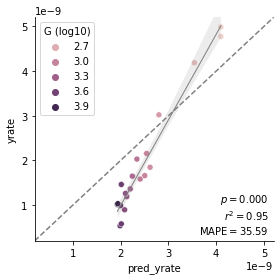

In [147]:
f,ax = plt.subplots(figsize=[4,4])
sns.scatterplot(data=pred_yrates, x="pred_yrate",y="yrate",ax=ax,hue="log_generation_time")
sns.regplot(data=pred_yrates, x="pred_yrate",y="yrate",ax=ax,color="gray",scatter=False,line_kws={"linewidth":1})
r,pval = stats.pearsonr(pred_yrates.pred_yrate,pred_yrates.yrate)
r2 = r**2
#mae = mean_absolute_error(pred_yrates.pred_yrate,pred_yrates.yrate)
mape = mean_absolute_percentage_error(pred_yrates.pred_yrate,pred_yrates.yrate)
ax.text(s = r"$p={:.3f}$".format(pval) + "\n" + r"$r^2={:.2f}$".format(r2) + "\n" + r"MAPE$={:.2f}$".format(mape),
        x=0.98, y=0.02, va="bottom",ha="right", transform=ax.transAxes,color="black")
axes_ranges = [0.2e-9,5.2e-9]
ax.set_xlim(axes_ranges)
ax.set_ylim(axes_ranges)
ax.legend(title="G (log10)")
sns.despine()
identity_line(color="gray")
plt.tight_layout()
plt.savefig("../../notebooks/pdfs/Predicted_yearly_rates_unfiform_age_effect.pdf")